In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader, random_split
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
import time

# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
path = 'lfw'

In [3]:
transform    = transforms.Compose([transforms.ToTensor()])
image_dataset = ImageFolder(path, transform,)
train_size = int(0.75*len(image_dataset))
test_size = len(image_dataset)-train_size
train_data, test_data = random_split(image_dataset, [train_size, test_size])
train_loader = DataLoader(train_data, shuffle=True, batch_size=32)
test_loader = DataLoader(test_data, shuffle=False, batch_size=32)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


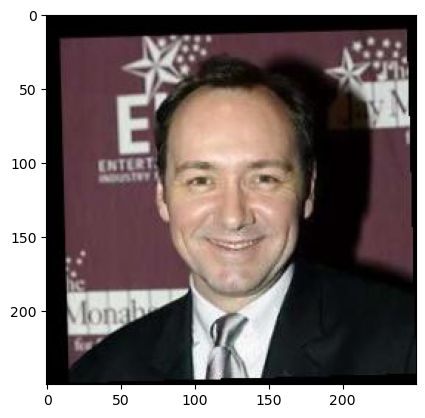

In [5]:
for x,y in train_loader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

In [6]:
for x, _ in train_loader:
    x = x.to("cuda")
    print(x.device)
    break

cuda:0


In [7]:
print(x.shape)

torch.Size([32, 3, 250, 250])


The dimension of the data is 32 by 3 by 250 by 250. The 32 is the batch size of the data. 3 is the 3 color channel. The two 250 are the height and width dimension of the image.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In this model we will use Conv2d, MaxPool2d, and Sigmoid for the encoder part. For the decoder part, we will use ConvTranspose2d, Sigmoid, UpSample, and Conv2d.

In [8]:
class AE(nn.Module):
    
    def __init__(self):
        super(AE,self).__init__()
        self.encoder1 = nn.Conv2d(in_channels=3, out_channels=10, stride=2, padding=3, kernel_size=10)
        self.encoder_activation1 = nn.Sigmoid()
        self.encoder2 = nn.Conv2d(in_channels=10, out_channels=16, stride=2, padding=2, kernel_size=8)
        self.encoder_activation2 = nn.Sigmoid()
        self.encoder3 = nn.MaxPool2d(kernel_size=3, padding=1, stride=2)
        self.encoder_activation3 = nn.Sigmoid()
        self.encoder4 = nn.Conv2d(in_channels=16, out_channels=8, stride=1, padding=1, kernel_size=5)
        self.encoder_activation4 = nn.Sigmoid()
        self.encoder5 = nn.Conv2d(in_channels=8, out_channels=6, stride=1, padding=1, kernel_size=5)
        self.encoder_activation5 = nn.Sigmoid()
        self.encoder6 = nn.Conv2d(in_channels=6, out_channels=2, stride=1, padding=1, kernel_size=3)
        self.encoder_activation6 = nn.Sigmoid()
        self.decoder1 = nn.ConvTranspose2d(in_channels=2,out_channels=6, stride=2, padding=1, kernel_size=5)
        self.decoder_activation1 = nn.Sigmoid()
        self.decoder2 = nn.ConvTranspose2d(in_channels=6, out_channels=10, stride=2, padding=1, kernel_size=4)
        self.decoder_activation2 = nn.Sigmoid()
        self.decoder3 = nn.Upsample(scale_factor=(2, 2), mode='nearest')
        self.decoder4 = nn.Conv2d(in_channels=10, out_channels=8, stride=1, dilation=1, padding=1, kernel_size=15)
        self.decoder_activation3 = nn.Sigmoid()
        self.decoder5 = nn.Upsample(scale_factor=(2, 2), mode='nearest')
        self.decoder6 = nn.Conv2d(in_channels=8, out_channels=5, stride=1, dilation=2, padding=1, kernel_size=15)
        self.decoder_activation4 = nn.Sigmoid()
        self.decoder7 = nn.Upsample(scale_factor=(2,2), mode='nearest')
        self.decoder8 = nn.Conv2d(in_channels=5, out_channels=3, stride=3, dilation=2, padding=1, kernel_size=17)
        self.decoder_activation5 = nn.Sigmoid()
    def encoder(self,x):
        layer1 = self.encoder_activation1(self.encoder1(x))
        layer2 = self.encoder_activation2(self.encoder2(layer1))
        layer3 = self.encoder_activation3(self.encoder3(layer2))
        layer4 = self.encoder_activation4(self.encoder4(layer3))
        layer5 = self.encoder_activation5(self.encoder5(layer4))
        out = self.encoder_activation6(self.encoder6(layer5))
        return out
    
    def decoder(self,x):
        layer1 = self.decoder_activation1(self.decoder1(x))
        layer2 = self.decoder_activation2(self.decoder2(layer1))
        layer3 = self.decoder3(layer2)
        layer4 = self.decoder_activation3(self.decoder4(layer3))
        layer5 = self.decoder5(layer4)
        layer6 = self.decoder_activation4(self.decoder6(layer5))
        layer7 = self.decoder7(layer6)
        out = self.decoder_activation5(self.decoder8(layer7))
        return out
        
    def forward(self,x):
        return self.decoder(self.encoder(x))

       

In [9]:
autoencoder = AE()

In [10]:
autoencoder.to("cuda")

AE(
  (encoder1): Conv2d(3, 10, kernel_size=(10, 10), stride=(2, 2), padding=(3, 3))
  (encoder_activation1): Sigmoid()
  (encoder2): Conv2d(10, 16, kernel_size=(8, 8), stride=(2, 2), padding=(2, 2))
  (encoder_activation2): Sigmoid()
  (encoder3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder_activation3): Sigmoid()
  (encoder4): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (encoder_activation4): Sigmoid()
  (encoder5): Conv2d(8, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (encoder_activation5): Sigmoid()
  (encoder6): Conv2d(6, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_activation6): Sigmoid()
  (decoder1): ConvTranspose2d(2, 6, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (decoder_activation1): Sigmoid()
  (decoder2): ConvTranspose2d(6, 10, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (decoder_activation2): Sigmoid()
  (decoder3): Upsample(scale_factor=(2.0, 2.0), mode='ne

In [11]:
next(autoencoder.parameters()).device

device(type='cuda', index=0)

In [12]:
encoded = autoencoder.encoder(x)

In [13]:
print(encoded.shape)

torch.Size([32, 2, 27, 27])


In [14]:
print(autoencoder.decoder(encoded).shape)

torch.Size([32, 3, 250, 250])


In [15]:
pytorch_total_params = sum(p.numel() for p in autoencoder.parameters())

In [16]:
print(pytorch_total_params)

50417


In [17]:
y = autoencoder.decoder(encoded)

In [18]:
y = y.cpu()

In [19]:
y = y[0].permute(1, 2, 0)

In [20]:
print(y.shape)

torch.Size([250, 250, 3])


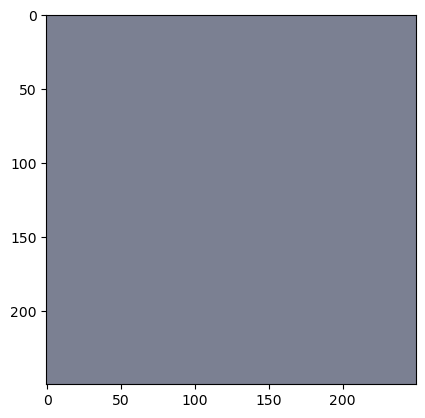

In [21]:
plt.imshow(y.detach().numpy())

## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

Let initialize our model by calling the constructor on AE and assign it to model

In [22]:
model = AE()

Next we will move our model into GPU for faster training since it is available to us.

In [23]:
model.to("cuda")

AE(
  (encoder1): Conv2d(3, 10, kernel_size=(10, 10), stride=(2, 2), padding=(3, 3))
  (encoder_activation1): Sigmoid()
  (encoder2): Conv2d(10, 16, kernel_size=(8, 8), stride=(2, 2), padding=(2, 2))
  (encoder_activation2): Sigmoid()
  (encoder3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder_activation3): Sigmoid()
  (encoder4): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (encoder_activation4): Sigmoid()
  (encoder5): Conv2d(8, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (encoder_activation5): Sigmoid()
  (encoder6): Conv2d(6, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_activation6): Sigmoid()
  (decoder1): ConvTranspose2d(2, 6, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (decoder_activation1): Sigmoid()
  (decoder2): ConvTranspose2d(6, 10, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (decoder_activation2): Sigmoid()
  (decoder3): Upsample(scale_factor=(2.0, 2.0), mode='ne

Let's encode our input and print out the shape.

In [24]:
encoded = model.encoder(x)
print(encoded.shape)

torch.Size([32, 2, 27, 27])


We can see that our input has been reduced from 3 by 250 by 250 to 2 by 27 by 27 through our encoder. Next let use the encoded data and put it through the decoder to make sure that it decodes the data back to the right size which is 3 by 250 by 250. The number 32 should stay the same since it is the batch size.

In [25]:
decoded = model.decoder(encoded)
print(decoded.shape)

torch.Size([32, 3, 250, 250])


This confirm that we the model work correctly as we wanted it to.

##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

This code was borrow from stack overflow. Source: https://stackoverflow.com/questions/49201236/check-the-total-number-of-parameters-in-a-pytorch-model

In [26]:
total_params = sum(p.numel() for p in autoencoder.parameters())
print(total_params)

50417


In [27]:
optim = torch.optim.Adam(model.parameters(), lr=0.0001)

Since we are trying to minimize the different between the input image X and the reconstructed image X', we are going to use MSELoss as our loss function.

In [28]:
loss_function = nn.MSELoss()

##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

Let define a function that will train the model for one epoch and report the average loss in that epoch for us.

In [29]:
def time_elapse(start):
    result = time.time()-start
    hours = int(result // 3600)
    minutes = int((result % 3600) // 60)
    seconds = result % 60
    return f"{hours}h:{minutes}m:{seconds:.2f}s"

In [30]:
def train_one_epoch(start_time):
    last_loss = 0
    for i, data in enumerate(train_loader):
        inputs = data[0]
        inputs = inputs.to("cuda")
        optim.zero_grad()
        outputs = model.forward(inputs)
        loss = loss_function(outputs, inputs)
        loss.backward()
        optim.step()
        running_loss = loss.item()
        print(" Batch {} loss: {} Time elapsed: {}".format(i+1, running_loss, time_elapse(start_time)))
        last_loss += running_loss
    avg_train_loss = last_loss/(i+1)
    return avg_train_loss
    

In [31]:
epoch_number = 0
EPOCHS = 50
for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number+1))
    model.train(True)
    time_start = time.time()
    avg_train_loss = train_one_epoch(time_start)
    running_test_loss = 0.0
    model.eval()
    with torch.no_grad():
        for i, test_data in enumerate(test_loader):
            test_inputs = test_data[0]
            test_inputs = test_inputs.to("cuda")
            test_outputs = model.forward(inputs)
            test_loss = loss_function(inputs, outputs)
            running_test_loss += test_loss
            print(' Batch {} test loss: {} Time elapsed: {}'.format(i+1, running_test_loss, time_elapse(time_start)))
    avg_test_loss = running_test_loss/(i+1)
    print(' Average train loss: {}'.format(avg_train_loss))
    print(' Average test loss: {}'.format(avg_test_loss))
    epoch_number += 1

EPOCH 1:
 Batch 1 loss: 0.10543984174728394 Time elapsed: 0h:0m:0.88s
 Batch 2 loss: 0.09612175077199936 Time elapsed: 0h:0m:1.62s
 Batch 3 loss: 0.08921542763710022 Time elapsed: 0h:0m:2.36s
 Batch 4 loss: 0.09126194566488266 Time elapsed: 0h:0m:3.09s
 Batch 5 loss: 0.08664137125015259 Time elapsed: 0h:0m:3.83s
 Batch 6 loss: 0.08672550320625305 Time elapsed: 0h:0m:4.56s
 Batch 7 loss: 0.07944295555353165 Time elapsed: 0h:0m:5.29s
 Batch 8 loss: 0.08114021271467209 Time elapsed: 0h:0m:6.04s
 Batch 9 loss: 0.07674866914749146 Time elapsed: 0h:0m:6.79s
 Batch 10 loss: 0.07181166112422943 Time elapsed: 0h:0m:7.52s
 Batch 11 loss: 0.07887556403875351 Time elapsed: 0h:0m:8.26s
 Batch 12 loss: 0.0826343521475792 Time elapsed: 0h:0m:9.00s
 Batch 13 loss: 0.1001603975892067 Time elapsed: 0h:0m:9.77s
 Batch 14 loss: 0.07818086445331573 Time elapsed: 0h:0m:10.51s
 Batch 15 loss: 0.07961681485176086 Time elapsed: 0h:0m:11.26s
 Batch 16 loss: 0.07551420480012894 Time elapsed: 0h:0m:12.02s
 Batch 

ValueError: too many values to unpack (expected 2)

##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

In [ ]:
plt.imshow()

##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?